In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold, LeaveOneGroupOut, StratifiedKFold
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
from tqdm import tqdm
import itertools
from sklearn.preprocessing import StandardScaler

In [2]:
inDIR = '../data/training/'
inFILE = 'vor_2013_2022_cln_2023_08_29_transect_hls_idxs.csv'

inPATH = os.path.join(inDIR, inFILE)

outDIR = './results/'

var_names = ['dfi', 'ndvi', 'ndti', 'satvi', 'ndii7', 
             'blue', 'green', 'red', 'nir', 'swir1', 'swir2',
             'bai_126', 'bai_136', 'bai_146', 'bai_236', 'bai_246', 'bai_346']

var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'BLUE': 'blue',
    'GREEN': 'green',
    'RED': 'red',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}

xv_vars = ['dfi', 'ndti', 'satvi', 'ndii7', 'swir1', 'swir2']
nsplits = 10

rand_st = 2313

In [3]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [4]:
df_results = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results.csv"))
df_results_full = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results_full.csv"))

In [5]:
df_vor = pd.read_csv(inPATH, parse_dates=[2, 3])
df_vor = df_vor.rename(columns=var_dict)

In [6]:
df_vor = df_vor[df_vor['Season'].isin(['June', 'October'])].copy()
#df_vor = df_vor[df_vor['Year'] >= 2017].copy()

In [7]:
# check for any missing data
len(df_vor[df_vor[var_names].isnull().any(axis=1)])

28

In [8]:
# remove missing data
df_vor = df_vor[~df_vor[var_names].isnull().any(axis=1)].copy()
#df_vor = df_vor[~df_vor['Id'].isin(df_vor[df_vor[var_names].isnull().any(axis=1)]['Id'].unique())].copy()

In [9]:
X_vars_all = df_vor[var_names]
Y_var_all = df_vor['Biomass_kg_ha']

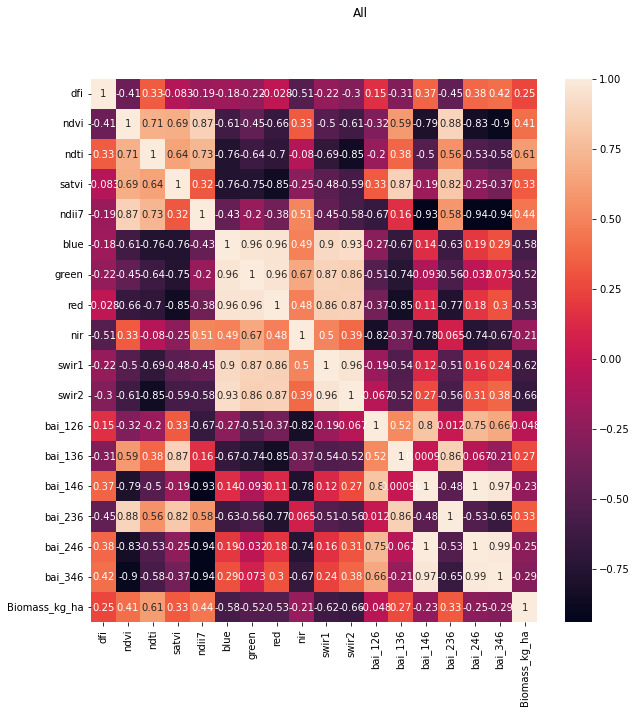

In [10]:
corrMatrix = X_vars_all.reset_index(drop=True).join(Y_var_all.reset_index(drop=True)).corr()
plt.figure(figsize=(10, 10))
plt.suptitle('All')
sns.heatmap(corrMatrix, annot=True)
plt.show()

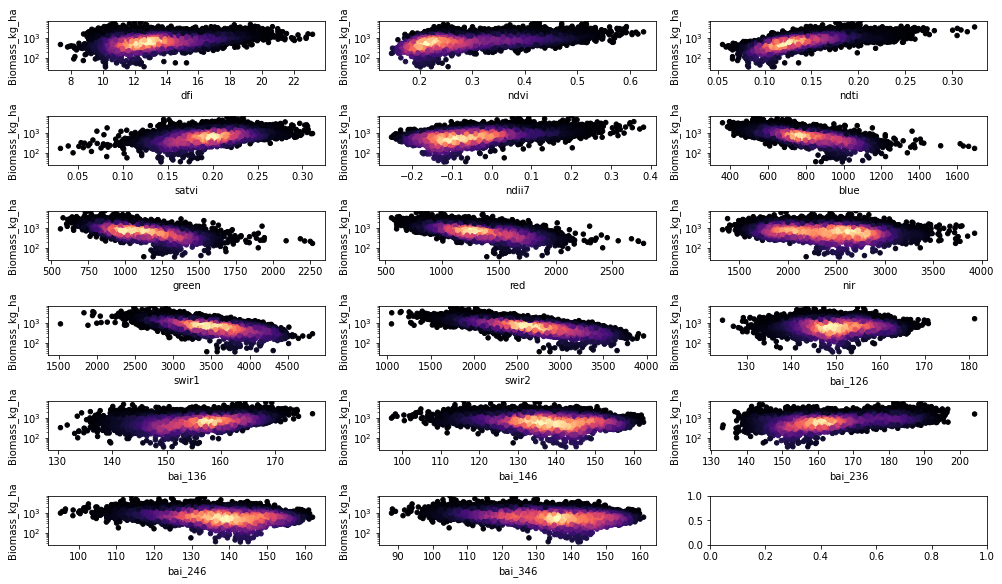

In [11]:
fig, axs = plt.subplots(figsize=(14, 8),
                        nrows=int(np.ceil(len(var_names) / 3)), ncols=3)
for idx, v in enumerate(var_names):
    xy_bm = np.vstack([df_vor[v], df_vor['Biomass_kg_ha']])
    z_bm = gaussian_kde(xy_bm)(xy_bm)
    df_vor.plot.scatter(x=v, y='Biomass_kg_ha', logy=True, ax=axs.flatten()[idx], ylim=(25, 7000),
                            c=z_bm, cmap='magma', colorbar=False)
    plt.tight_layout(pad=1.0)

In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR

In [ ]:
lr_form = df_results['formula'][413]

df_vor['bm_pred_rf_yr'] = np.nan
df_vor['bm_pred_rft_yr'] = np.nan
df_vor['bm_pred_lr_yr'] = np.nan
df_vor['bm_pred_mlp_yr'] = np.nan
df_vor['bm_pred_pls_yr'] = np.nan
df_vor['bm_pred_svr_yr'] = np.nan

var_names_simp = list(X_vars_all.columns)

scaler = StandardScaler()
mod_logo = LeaveOneGroupOut()
mod_skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rand_st)
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error', 'MAPE': 'neg_mean_absolute_percentage_error'}
param_grid = {
    'bootstrap': [True],
    'max_depth': [None],
    'max_features': [2, 4, 6, len(var_names_simp)],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5],
    'n_estimators': [500, 1000]
}

simp = True
log_xfrm = True
log_xfrm_pls = False
wtd = False
smap_xv = False
tune_rf = True
scale_vars = True
fit_mlp = True
fit_pls = True
tune_pls = True
fit_svr = True
mae_all_full_ktests = []
mae_all_full_lr_ktests = []
mae_tuned_ktests = []
mae_mlp_ktests = []
mae_pls_ktests = []
mae_svr_ktests = []
n_comps = []
for train_index, test_index in mod_logo.split(X_vars_all, groups=df_vor['Date'].dt.year, ):
    print("Running K-fold = " + str(df_vor['Date'].dt.year.iloc[test_index].unique()))
    rf_all_tmp = RandomForestRegressor(n_estimators=500, random_state=rand_st)
    if wtd:
        lreg_tmp = smf.wls(formula=lr_form,
                           data=df_vor.iloc[train_index], weights=1 / df_vor.Biomass_kg_ha.iloc[train_index]).fit()
    else:
        lreg_tmp = smf.ols(formula=lr_form,
                           data=df_vor.iloc[train_index]).fit()
    if log_xfrm:
        see_tmp = np.sqrt(np.sum((np.log(df_vor['Biomass_kg_ha'].iloc[train_index]) -
                                  lreg_tmp.predict(df_vor.iloc[train_index])) ** 2) /
                          (len(train_index) - len(lreg_tmp.params)))
        cf_tmp = np.exp(see_tmp ** 2 / 2)  # correction factor from Sprugel 1983
        predictions_all_lr_tmp = np.exp(lreg_tmp.predict(df_vor.iloc[test_index])) # * cf_tmp
    else:
        predictions_all_lr_tmp = lreg_tmp.predict(df_vor.iloc[test_index])
    if simp:
        all_X = df_vor[var_names_simp].iloc[test_index, :]
        all_x = df_vor[var_names_simp].iloc[train_index, :]
        scaler.fit(all_x)
    else:
        all_X = df_vor[var_names + xv_names].iloc[test_index, :]
        all_x = df_vor[var_names + xv_names].iloc[train_index, :]
        scaler.fit(all_x)
    if scale_vars:
        all_x = scaler.transform(all_x)
        all_X = scaler.transform(all_X)
    all_y = Y_var_all.iloc[train_index]
    rf_all_tmp.fit(all_x, all_y)

    all_Y = Y_var_all.iloc[test_index]
    predictions_all_tmp = rf_all_tmp.predict(all_X)
    mae_all_full_ktests.append(round(np.mean(np.abs(predictions_all_tmp - all_Y)), 2))
    mae_all_full_lr_ktests.append(round(np.mean(np.abs(predictions_all_lr_tmp - all_Y)), 2))
    
    df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
    df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp
    
    if tune_rf:
        #rf_cv_all = mod_skf.split(all_x, df_vor['Year'].iloc[train_index])
        rf_cv_all = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])

        # Create a base model
        rf_all_m1 = RandomForestRegressor(random_state=rand_st)
        # Instantiate the grid search model
        grid_search_all_m1 = GridSearchCV(estimator=rf_all_m1,
                                          param_grid=param_grid,
                                          scoring=scoring, 
                                          refit='MAPE', 
                                          return_train_score=True,
                                          cv=rf_cv_all, 
                                          n_jobs=-1, 
                                          verbose=0)
        grid_search_all_m1.fit(all_x, all_y)
        params_all_m1 = grid_search_all_m1.best_params_
        rf_all_m2 = RandomForestRegressor(n_estimators=params_all_m1['n_estimators'],
                                          min_samples_split=params_all_m1['min_samples_split'],
                                          min_samples_leaf=params_all_m1['min_samples_leaf'],
                                          max_features=params_all_m1['max_features'],
                                          bootstrap=params_all_m1['bootstrap'],
                                          max_depth=params_all_m1['max_depth'],
                                          random_state=rand_st)
        rf_all_m2.fit(all_x, all_y)
        # Use the forest's predict method on the test data
        predictions_all_tmp_m2 = rf_all_m2.predict(all_X)
        mae_tuned_ktests.append(round(np.mean(np.abs(predictions_all_tmp_m2 - all_Y)), 2))
        df_vor['bm_pred_rft_yr'].iloc[test_index] = predictions_all_tmp_m2
    if fit_mlp:
        mlp_all = MLPRegressor(solver='lbfgs', learning_rate='adaptive', max_iter=2000)
        mlp_all.fit(all_x, all_y)
        predictions_all_tmp_mlp = mlp_all.predict(all_X)
        mae_mlp_ktests.append(round(np.mean(np.abs(predictions_all_tmp_mlp - all_Y)), 2))
        df_vor['bm_pred_mlp_yr'].iloc[test_index] = predictions_all_tmp_mlp
    if fit_pls:
        if tune_pls:
            param_grid_pls = {'n_components': np.arange(1, len(var_names))}
            pls_cv_all = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])
            
            # Create a base model
            pls_all_m1 = PLSRegression(scale=False)
            # Instantiate the grid search model
            grid_search_all_m1 = GridSearchCV(estimator=pls_all_m1,
                                              param_grid=param_grid_pls,
                                              scoring=scoring, 
                                              refit='MAPE', 
                                              return_train_score=True,
                                              cv=pls_cv_all, 
                                              n_jobs=-1, 
                                              verbose=0)
            if log_xfrm_pls:
                grid_search_all_m1.fit(all_x, np.log(all_y))
            else:
                grid_search_all_m1.fit(all_x, all_y)
            params_all_m1 = grid_search_all_m1.best_params_
            n_comps.append(params_all_m1['n_components'])
            pls_all = PLSRegression(n_components=params_all_m1['n_components'])
        else:
            pls_all = PLSRegression(n_components=10)
        if log_xfrm_pls:
            pls_all.fit(all_x, np.log(all_y))
            predictions_all_tmp_pls = np.exp(pls_all.predict(all_X).squeeze())
        else:
            pls_all.fit(all_x, all_y)
            predictions_all_tmp_pls = pls_all.predict(all_X).squeeze()
        mae_pls_ktests.append(round(np.mean(np.abs(predictions_all_tmp_pls - all_Y)), 2))
        df_vor['bm_pred_pls_yr'].iloc[test_index] = predictions_all_tmp_pls
    if fit_svr:
        svr_all = SVR()
        svr_all.fit(all_x, all_y)
        predictions_all_tmp_svr = svr_all.predict(all_X).squeeze()
        mae_svr_ktests.append(round(np.mean(np.abs(predictions_all_tmp_svr - all_Y)), 2))
        df_vor['bm_pred_svr_yr'].iloc[test_index] = predictions_all_tmp_svr

Running K-fold = [2013]


/tmp/ipykernel_9586/3866747161.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_rf_yr'].iloc[test_index] = predictions_all_tmp
/tmp/ipykernel_9586/3866747161.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor['bm_pred_lr_yr'].iloc[test_index] = predictions_all_lr_tmp


In [ ]:
n_comps

In [15]:
print("---- RF -----")
print("MAE: " + str(np.round(np.mean(mae_all_full_ktests), 2)) + " (sd = " +
      str(np.round(np.std(mae_all_full_ktests), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(
    np.array(mae_all_full_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean()), 2)))
print("MPE by year: ")
print(np.array(mae_all_full_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

if tune_rf:
    print("---- RF Tuned -----")
    print("MAE: " + str(np.round(np.mean(mae_tuned_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_tuned_ktests), 2)) + ") kg/ha")
    print("MAE by year: ")
    print(np.array(mae_tuned_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

print("---- LR -----")
print("MAE: " + str(np.round(np.mean(mae_all_full_lr_ktests), 2)) + " (sd = " +
      str(np.round(np.std(mae_all_full_lr_ktests), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(
    np.array(mae_all_full_lr_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean()), 2)))
print("MPE by year: ")
print(np.array(mae_all_full_lr_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

if fit_mlp:
    print("---- MLP -----")
    print("MAE: " + str(np.round(np.mean(mae_mlp_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_mlp_ktests), 2)) + ") kg/ha")
    print("MPE: " + str(np.round(np.mean(
        np.array(mae_mlp_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean()), 2)))
    print("MPR by year: ")
    print(np.array(mae_mlp_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

if fit_pls:
    print("---- PLS -----")
    print("MAE: " + str(np.round(np.mean(mae_pls_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_pls_ktests), 2)) + ") kg/ha")
    print("MPE: " + str(np.round(np.mean(
        np.array(mae_pls_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean()), 2)))
    print("MPE by year:")
    print(np.array(mae_pls_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())
if fit_svr:
    print("----- SVR -----")
    print("MAE: " + str(np.round(np.mean(mae_svr_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_svr_ktests), 2)) + ") kg/ha")
    print("MPE: " + str(np.round(np.mean(
        np.array(mae_svr_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean()), 2)))
    print("MPE by year: ")
    print(np.array(mae_svr_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

---- RF -----
MAE: 275.32 (sd = 116.9) kg/ha
MPE: 0.3
MPE by year: 
Date
2013    0.359896
2014    0.258083
2015    0.491627
2016    0.255621
2017    0.238690
2018    0.291083
2019    0.214634
2020    0.225860
2021    0.304764
2022    0.396432
Name: Biomass_kg_ha, dtype: float64
---- LR -----
MAE: 243.4 (sd = 81.65) kg/ha
MPE: 0.27
MPE by year: 
Date
2013    0.285554
2014    0.281541
2015    0.253950
2016    0.333020
2017    0.201607
2018    0.261178
2019    0.210519
2020    0.203594
2021    0.294560
2022    0.365406
Name: Biomass_kg_ha, dtype: float64
---- MLP -----
MAE: 442.1 (sd = 234.88) kg/ha
MPE: 0.49
MPR by year: 
Date
2013    0.752465
2014    0.357677
2015    0.931677
2016    0.352902
2017    0.392087
2018    0.324181
2019    0.330823
2020    0.431603
2021    0.487250
2022    0.564178
Name: Biomass_kg_ha, dtype: float64
---- PLS -----
MAE: 244.39 (sd = 70.71) kg/ha
MPE: 0.28
MPE by year:
Date
2013    0.325358
2014    0.256820
2015    0.302267
2016    0.234094
2017    0.208185
20

In [18]:
df_vor['Id_plot'] = df_vor['Id'].apply(lambda x: '_'.join(x.split('_')[:-1]))

In [52]:
ae_plot_rf = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_rf_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_rf = ae_plot_rf / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_lr = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_lr_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_lr = ae_plot_lr / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_pls = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_pls_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_pls = ae_plot_pls / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_svr = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_svr_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_svr = ae_plot_svr / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

ae_plot_mlp = abs(df_vor.groupby(['Id_plot', 'Date'])['bm_pred_mlp_yr'].mean() - \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean())
pe_plot_mlp = ae_plot_mlp / \
df_vor.groupby(['Id_plot', 'Date'])['Biomass_kg_ha'].mean()

In [54]:
print("---- RF -----")
print("MAE: " + str(np.round(np.mean(ae_plot_rf), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_rf)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_rf), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_rf, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

print("---- LR -----")
print("MAE: " + str(np.round(np.mean(ae_plot_lr), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_lr)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_lr), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_lr, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

print("---- PLS -----")
print("MAE: " + str(np.round(np.mean(ae_plot_pls), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_pls)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_pls), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_pls, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

print("---- SVR -----")
print("MAE: " + str(np.round(np.mean(ae_plot_svr), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_svr)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_svr), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_svr, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

print("---- MLP -----")
print("MAE: " + str(np.round(np.mean(ae_plot_mlp), 2)) + " (sd = " +
      str(np.round(np.std(abs(ae_plot_mlp)), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(pe_plot_mlp), 2)))
print("MPE by year: ")
print(pd.Series(pe_plot_mlp, name='PE').reset_index().groupby(
    df_vor.groupby(['Id_plot', 'Date']).first().reset_index()['Date'].dt.year)['PE'].mean())

---- RF -----
MAE: 265.31 (sd = 286.31) kg/ha
MPE: 0.34
MPE by year: 
Date
2013    0.497793
2014    0.281717
2015    0.534212
2016    0.273734
2017    0.255946
2018    0.307940
2019    0.192436
2020    0.285963
2021    0.263749
2022    0.528936
Name: PE, dtype: float64
---- LR -----
MAE: 229.75 (sd = 261.48) kg/ha
MPE: 0.28
MPE by year: 
Date
2013    0.365819
2014    0.279973
2015    0.267553
2016    0.233006
2017    0.207298
2018    0.255255
2019    0.192227
2020    0.210289
2021    0.273150
2022    0.504964
Name: PE, dtype: float64
---- PLS -----
MAE: 237.04 (sd = 249.3) kg/ha
MPE: 0.31
MPE by year: 
Date
2013    0.470514
2014    0.281718
2015    0.372098
2016    0.234086
2017    0.256183
2018    0.281197
2019    0.176942
2020    0.239549
2021    0.278720
2022    0.567636
Name: PE, dtype: float64
---- SVR -----
MAE: 275.46 (sd = 312.2) kg/ha
MPE: 0.35
MPE by year: 
Date
2013    0.456613
2014    0.355399
2015    0.291708
2016    0.244518
2017    0.234795
2018    0.311508
2019    0.205

In [ ]:
if tune_rf:
    print("---- RF Tuned -----")
    print("MAE: " + str(np.round(np.mean(mae_tuned_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_tuned_ktests), 2)) + ") kg/ha")
    print("MAE by year: ")
    print(np.array(mae_tuned_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

print("---- LR -----")
print("MAE: " + str(np.round(np.mean(mae_all_full_lr_ktests), 2)) + " (sd = " +
      str(np.round(np.std(mae_all_full_lr_ktests), 2)) + ") kg/ha")
print("MPE: " + str(np.round(np.mean(
    np.array(mae_all_full_lr_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean()), 2)))
print("MPE by year: ")
print(np.array(mae_all_full_lr_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

if fit_mlp:
    print("MLP model MAE: " + str(np.round(np.mean(mae_mlp_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_mlp_ktests), 2)) + ") kg/ha")
    print("Precent RMSE MLP model: ")
    print(np.array(mae_mlp_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

if fit_pls:
    print("---- PLS -----")
    print("MAE: " + str(np.round(np.mean(mae_pls_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_pls_ktests), 2)) + ") kg/ha")
    print("MPE: " + str(np.round(np.mean(
        np.array(mae_pls_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean()), 2)))
    print("MPE by year:")
    print(np.array(mae_pls_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())
if fit_svr:
    print("SVR model MAE: " + str(np.round(np.mean(mae_svr_ktests), 2)) + " (sd = " +
          str(np.round(np.std(mae_svr_ktests), 2)) + ") kg/ha")
    print("Precent RMSE original SVR model: ")
    print(np.array(mae_svr_ktests) / df_vor.groupby(df_vor['Date'].dt.year)['Biomass_kg_ha'].mean())

In [35]:
pls_all.score(all_x, all_y)

0.5604764914272244

Bad pipe message: %s [b'\xf9k\xe7\x8e\xeb:\x90\xee\xb7\x01EbJW\xb0k\x95\xb1\x00\x01p\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00A\x00B\x00C\x00D\x00E\x00F\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0', b'\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15']
Bad pipe message: %s [b'\x98\x8e\x9a\xf9o\xbf\x1b\x84\x98\xe2\xbc>N\xaci\xc7\x1a\x1d\x00\x01p\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07